In [73]:
from pathlib import Path

import awkward as ak
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, skew
import analysis

In [74]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Import

In [75]:
inputDir = Path("../output_odd_g4_n20_4GeV")

summary_gsf_root = uproot.open(str(inputDir / "root/tracksummary_gsf.root:tracksummary"))
states_gsf_root = uproot.open(str(inputDir / "root/trackstates_gsf.root:trackstates"))

summary_kf_root = uproot.open(str(inputDir / "root/tracksummary_kf.root:tracksummary"))
states_kf_root = uproot.open(str(inputDir / "root/trackstates_kf.root:trackstates"))

In [76]:
summary_gsf, states_gsf = analysis.uproot_to_pandas(summary_gsf_root, states_gsf_root)
summary_kf, states_kf = analysis.uproot_to_pandas(summary_kf_root, states_kf_root)

In [77]:
summary_gsf.head(3)

,event_nr,multiTraj_nr,nStates,nMeasurements,nOutliers,nHoles,nSharedHits,chi2Sum,NDF,nMajorityHits,...,res_eT_fit,pull_eLOC0_fit,pull_eLOC1_fit,pull_ePHI_fit,pull_eTHETA_fit,pull_eQOP_fit,pull_eT_fit,p_fit,res_p_fit,t_delta_p
0,0,0,29,16,0,0,0,461.643494,25,16,...,-19.799847,-0.371561,0.332686,0.808677,-0.182028,1.009432,-0.006605,4.041830,0.042341,-0.321610
1,0,1,27,13,0,1,0,253.606323,21,13,...,-276.202301,-3.758646,0.576189,3.652858,0.705830,2.115512,-0.092131,4.356043,0.356554,-0.278488
2,0,2,30,13,2,2,0,264.800354,25,13,...,596.571960,-0.739004,0.270016,0.508274,0.613137,-0.711804,0.198995,3.963828,-0.035661,-3.375979


In [78]:
summary_kf.head(3)

,event_nr,multiTraj_nr,nStates,nMeasurements,nOutliers,nHoles,nSharedHits,chi2Sum,NDF,nMajorityHits,...,res_eT_fit,pull_eLOC0_fit,pull_eLOC1_fit,pull_ePHI_fit,pull_eTHETA_fit,pull_eQOP_fit,pull_eT_fit,p_fit,res_p_fit,t_delta_p
0,0,0,29,16,0,0,0,27.979639,25,16,...,-19.791748,-0.317358,0.280126,0.673799,-0.154840,0.650145,-0.006602,4.021216,0.021727,-0.321610
1,0,1,27,13,0,1,0,35.642956,21,13,...,-276.200226,-2.096152,0.248044,1.714896,0.105656,-2.841027,-0.092130,3.881758,-0.117731,-0.278488
2,0,2,30,15,0,2,0,9203.781250,25,15,...,594.114441,6.585731,1.112388,-9.488767,0.749347,-55.859322,0.198175,2.720290,-1.279199,-3.375979


## Overview plots

In [79]:
def all_residuals(df_gsf, df_kf):
    fig, axes = plt.subplots(2,3,figsize=(18,5))

    for ax, key, name, unit in zip(
        axes.flatten(),
        ['res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit', 'res_eQOP_fit', 'res_eT_fit'],
        ["d_0", "z", "\phi", "\\theta", "q/p", 't'],
        ["mm", "mm", "rad", "rad", "1/GeV", "ns"]
    ):
        _, bins = np.histogram(np.concatenate([df_gsf[key], df_kf[key]]), bins="rice")
        hist_opts = dict(alpha = 0.5, histtype='stepfilled', linewidth=1.2, edgecolor='black')
        ax.hist(df_kf[key], bins=bins, **hist_opts, label="KF")
        ax.hist(df_gsf[key], bins=bins, **hist_opts, label="GSF")
        ax.set_yscale('log')
        ax.set_title("${}$".format(name))
        ax.set_xlabel("${{{}}}_{{fit}} - {{{}}}_{{true}} \quad [{}]$".format(name, name, unit))

    axes[0,0].legend()
    return fig, axes

In [80]:
def delta_p_vs_res_qop(df_gsf, df_kf):
    fig, axes = plt.subplots(1,2,figsize=(16,5))
    
    for ax, df, fitter in zip(axes, [df_gsf, df_kf], ["GSF", "KF"]):
        ax.scatter(np.clip(df.res_eQOP_fit, -5,.5), df.t_delta_p, alpha=0.1)
        ax.set_ylabel("$\Delta p$ [GeV]")
        ax.set_xlabel("${q/p}_{{fit}} - {q/p}_{{true}} \quad [1/GeV]$")
        ax.set_title(fitter)
        ax.set_xlim(-5,.5)
        
    return fig, ax

In [81]:
"tracks with outliers : {:.2%}".format(sum(np.unique(summary_gsf["nOutliers"], return_counts=True)[1][1:]) / len(summary_gsf))

'tracks with outliers : 17.10%'

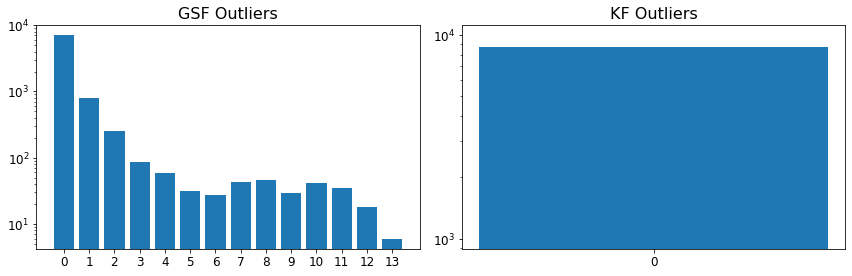

In [82]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

for ax, df, fitter in zip(axes, [summary_gsf, summary_kf], ["GSF", "KF"]):
    ax.bar(*np.unique(df["nOutliers"], return_counts=True))
    ax.set_title(f"{fitter} Outliers")
    ax.set_yscale('log')
    _ = ax.set_xticks(np.unique(df["nOutliers"]))
    
fig.tight_layout()

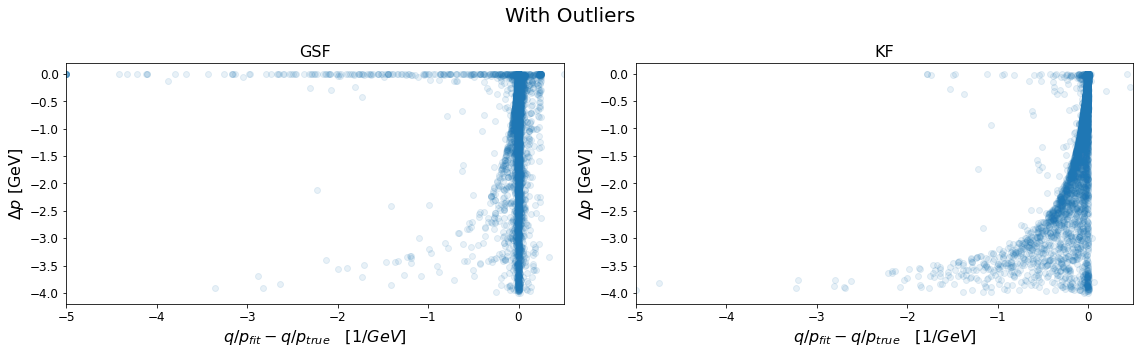

In [83]:
fig, _ = delta_p_vs_res_qop(summary_gsf, summary_kf)
fig.suptitle("With Outliers")
fig.tight_layout()

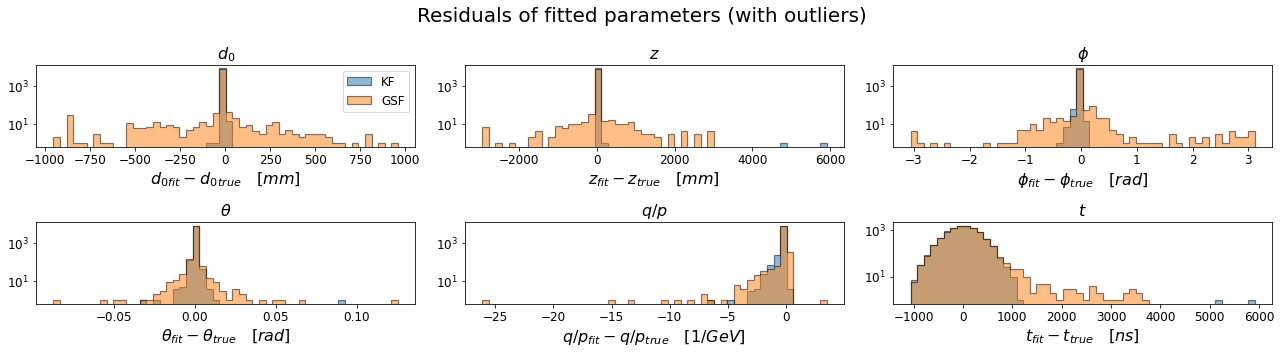

In [84]:
fig, _ = all_residuals(summary_gsf, summary_kf)
fig.suptitle("Residuals of fitted parameters (with outliers)")
fig.tight_layout()

## Remove outliers

In [85]:
summary_gsf_no_outliers = summary_gsf[ summary_gsf["nOutliers"] == 0 ]
common_idx = summary_gsf_no_outliers.index.intersection(summary_kf.index)

summary_kf_no_outliers = summary_kf.loc[common_idx, :]
summary_gsf_no_outliers = summary_gsf_no_outliers.loc[common_idx, :]

In [86]:
len(summary_gsf), len(summary_kf)

(8612, 8681)

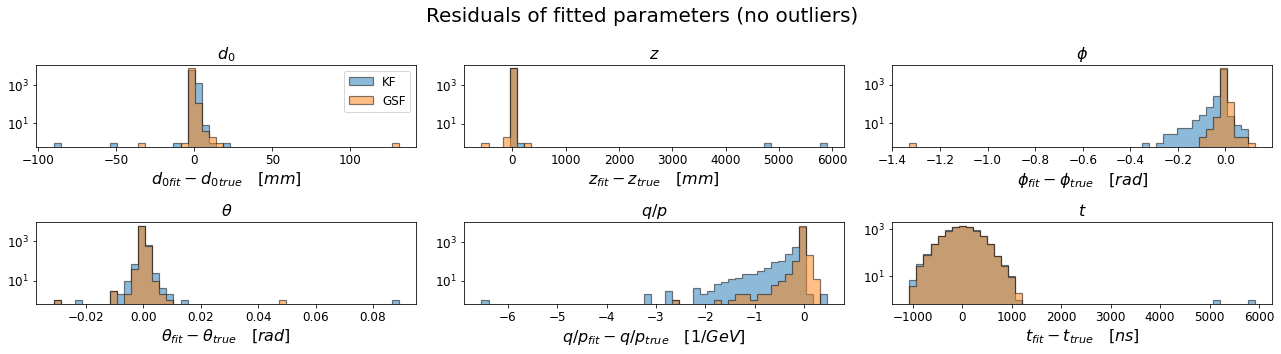

In [87]:
fig, _ = all_residuals(summary_gsf_no_outliers, summary_kf_no_outliers)
fig.suptitle("Residuals of fitted parameters (no outliers)")
fig.tight_layout()

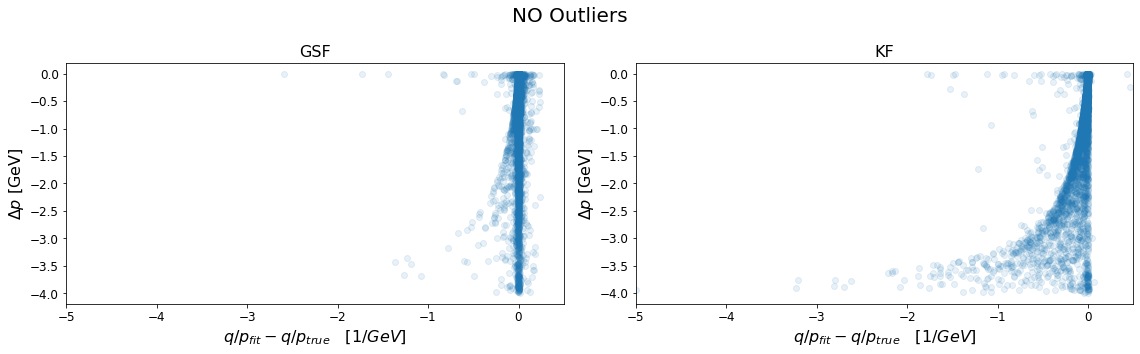

In [88]:
fig, _ = delta_p_vs_res_qop(summary_gsf_no_outliers, summary_kf_no_outliers)
fig.suptitle("NO Outliers")
fig.tight_layout()

## Core-Tail resolution

In [89]:
def analyse_core_tail(df, key, clip_range=None, core_share=0.95):
    hist, bins = np.histogram(np.clip(df[key],-3, 3), bins=300)
    argmax = np.argmax(hist)
    mode = 0.5 * (bins[argmax] + bins[argmax+1])
    
    print("mode", mode)
    print("mean", np.mean(df[key]))
    print("std", np.std(df[key]))
    print("rms", np.sqrt(np.mean(np.square(df[key]))))
    print("skewness", skew(df[key]))
          
    # Compute core range
    d = np.quantile(np.sort(abs(df[key])), core_share)     
    core_range = (-d, d)
    
    df["is_core"] = df[key].between(*core_range)
    
    core_percent = 100. * sum(df["is_core"]) / len(df)
    tail_percent = 100. - core_percent
    
    core_part = df[df["is_core"]]
    tail_part = df[np.logical_not(df["is_core"])]

    fit_core = norm.fit(core_part[key])
    fit_tail = norm.fit(tail_part[key])
    
    print("core range",min(core_part[key]),max(core_part[key]))
    print("tail range",min(tail_part[key]),max(tail_part[key]))
    
    if clip_range is None:
        clip_range = (
            min(min(core_part[key]), min(tail_part[key])),
            max(max(core_part[key]), max(tail_part[key]))
        )
        
    assert clip_range[0] < 0.0
    assert clip_range[1] > 0.0
        
    fig, ax = plt.subplots(1,3,figsize=(17,5))
     
    tail_label = "tail ({:.1f}%) | $\mu$={:.3f}, $\sigma$={:.2f}".format(tail_percent, *fit_tail)
    core_label = "core ({:.1f}%) | $\mu$={:.3f}, $\sigma$={:.2f}".format(core_percent, *fit_core)
    hist_options = dict(edgecolor='black', linewidth=1.2, stacked=True, label=[tail_label, core_label])
        
    # Whole plot
    _, bins = np.histogram(np.clip(df[key], *clip_range), bins=50)
    ax[0].hist([np.clip(tail_part[key], *clip_range), np.clip(core_part[key], *clip_range)], bins=bins, **hist_options)
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_title("Whole range")
    
    # Zoom plot
    zoom = lambda x: x[ np.logical_and(x > 3*core_range[0], x < 3*core_range[1]) ]
    
    _, bins = np.histogram(zoom(df[key]), bins=50)
    ax[1].hist([zoom(tail_part[key]), core_part[key]], bins=bins, **hist_options)
    ax[1].set_yscale('log')
    #ax[1].legend()
    ax[1].set_title("Zoom range")
    
    # Pull distribution core
    pull = core_part["pull_" + key[4:]]
    fit_pull = norm.fit(pull)
    ax[2].hist(pull, bins="rice", density=True, color="tab:orange")
    x = np.linspace(*ax[2].get_xlim(), 200)
    ax[2].plot(x, norm.pdf(x, *fit_pull), label="$\mu$={:.3f}, $\sigma$={:.3f}".format(*fit_pull), color='black', lw=2.0)
    ax[2].legend()
    ax[2].set_title("Pull")
        
    return fig, ax

### QOP

mode -0.0038284738548099995
mean -0.0059233634
std 0.06937199831008911
rms 0.06962446
skewness -16.653959496578334
core range -0.0628499984741211 0.06276826560497284
tail range -2.596625566482544 0.2370324581861496


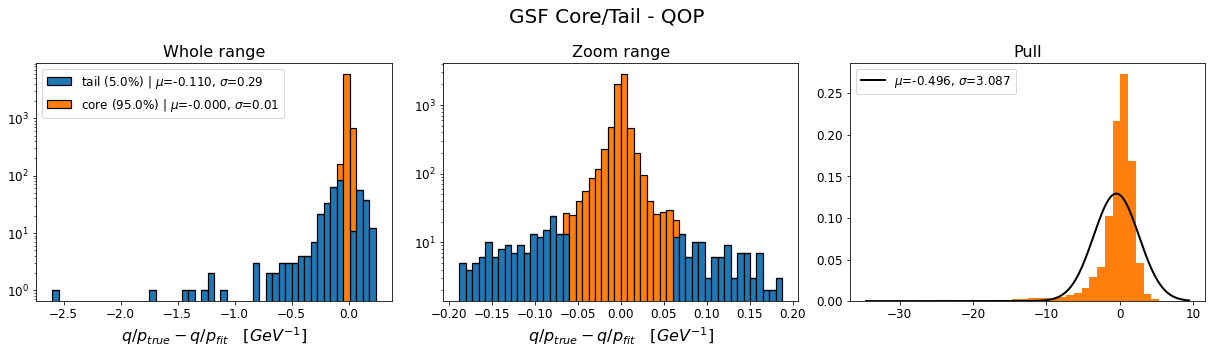

In [90]:
fig, axes = analyse_core_tail(summary_gsf_no_outliers, "res_eQOP_fit")
for ax in axes[:2]:
    ax.set_xlabel("$q/p_{true} - q/p_{fit} \quad [GeV^{-1}]$")
fig.suptitle("GSF Core/Tail - QOP")
fig.tight_layout()

mode -0.00347662391141057
mean -0.077122174
std 0.2306859940290451
rms 0.2432363
skewness -7.937542440439268
core range -0.4066616892814636 0.06349210441112518
tail range -6.533694267272949 0.4641888737678528


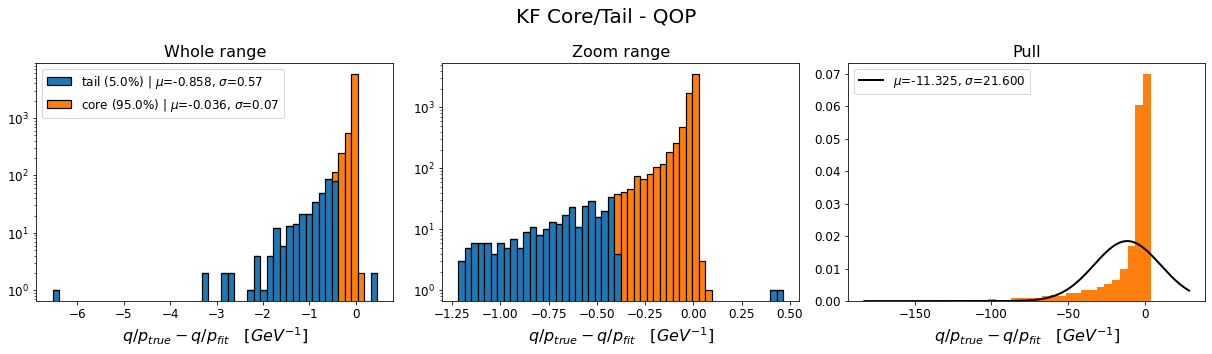

In [91]:
fig, axes = analyse_core_tail(summary_kf_no_outliers, "res_eQOP_fit")
for ax in axes:
    ax.set_xlabel("$q/p_{true} - q/p_{fit} \quad [GeV^{-1}]$")
fig.suptitle("KF Core/Tail - QOP")
fig.tight_layout()

### LOC0

mode -0.009999999776482582
mean 0.022432907
std 1.6356698274612427
rms 1.6358445
skewness 71.74843772933266
core range -0.11827129125595093 0.11789809912443161
tail range -32.015350341796875 131.37802124023438


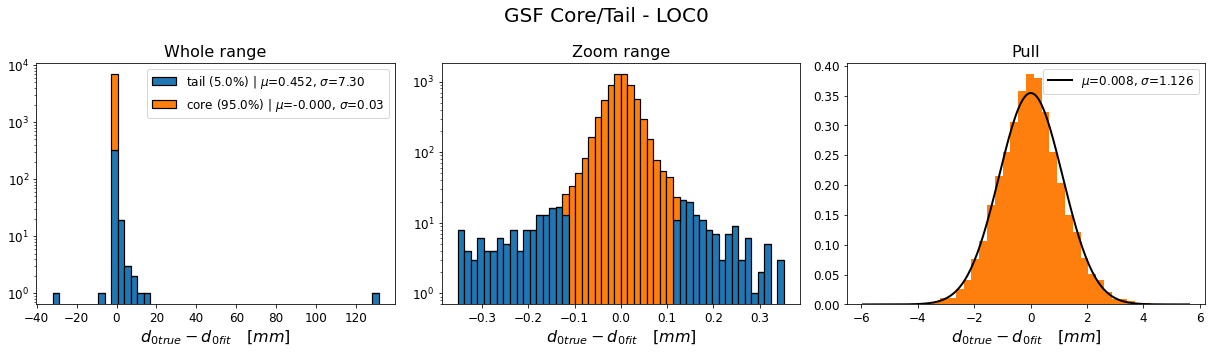

In [92]:
fig, axes = analyse_core_tail(summary_gsf_no_outliers, "res_eLOC0_fit")
for ax in axes:
    ax.set_xlabel("${d_0}_{true} - {d_0}_{fit} \quad [mm]$")
fig.suptitle("GSF Core/Tail - LOC0")
fig.tight_layout()

mode 0.009999999776482582
mean 0.10933832
std 1.3425748348236084
rms 1.3470216
skewness -50.32753257929031
core range -0.7029663920402527 0.7554522752761841
tail range -90.34346008300781 20.770780563354492


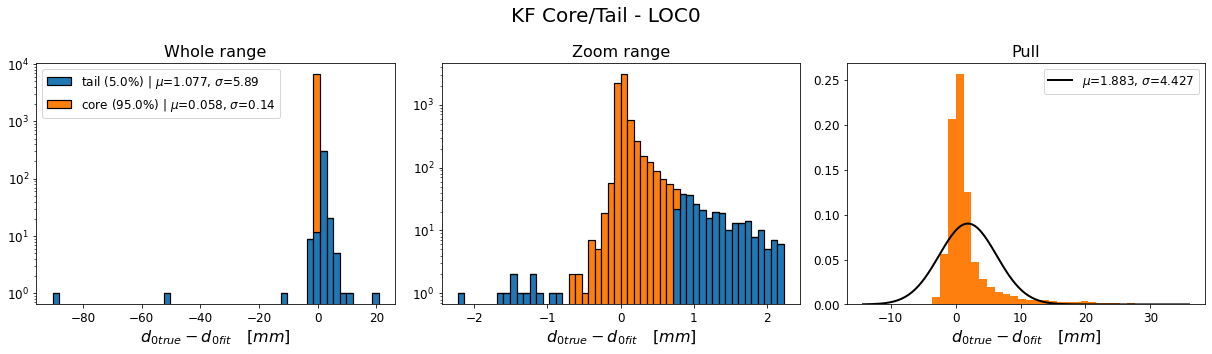

In [93]:
fig, axes = analyse_core_tail(summary_kf_no_outliers, "res_eLOC0_fit", (-100,100))
for ax in axes:
    ax.set_xlabel("${d_0}_{true} - {d_0}_{fit} \quad [mm]$")
fig.suptitle("KF Core/Tail - LOC0")
fig.tight_layout()